In [1]:
import sys, os

sys.path += ["../../external/"]

In [2]:
%load_ext autoreload
%autoreload 1
%aimport zero_order_gpmpc

In [3]:
import numpy as np
from scipy.stats import norm
import casadi as cas
from acados_template import (
    AcadosOcp,
    AcadosSim,
    AcadosSimSolver,
    AcadosOcpSolver,
    AcadosOcpOptions,
)
import matplotlib.pyplot as plt
import torch
import gpytorch
import copy

# zoRO imports
import zero_order_gpmpc
from zero_order_gpmpc.controllers import (
    ZeroOrderGPMPC,
)
from zero_order_gpmpc.controllers.zoro_acados_utils import setup_sim_from_ocp
from inverted_pendulum_model_acados import (
    export_simplependulum_ode_model,
    export_ocp_nominal,
)
from utils import *

# gpytorch_utils
from gpytorch_utils.gp_hyperparam_training import (
    generate_train_inputs_acados,
    generate_train_outputs_at_inputs,
    train_gp_model,
)
from gpytorch_utils.gp_utils import (
    gp_data_from_model_and_path,
    gp_derivative_data_from_model_and_path,
    plot_gp_data,
    generate_grid_points,
)
from zero_order_gpmpc.models.gpytorch_models.gpytorch_gp import (
    BatchIndependentMultitaskGPModel,
)

## Define model parameters

We model the inverted pendulum

$$
\dot{x} = f(x,u) = \begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\sin(\theta) + u \end{bmatrix},
$$

which is to be controlled from the hanging-down resting position, $(\theta_0, \dot{\theta}_0) = (\pi, 0)$, to the upright position ($(\theta_r, \dot{\theta}_r) = (0,0)$), subject to the constraints that overshoot should be avoided, i.e.,

$$
\theta_{lb} \leq \theta \leq \theta_{ub}.
$$

The model setup and controller definition can be found in the functions `export_simplependulum_ode_model()`, `export_ocp_nominal()` in the `inverted_pendulum_model_acados.py` file.

In [4]:
# build C code again?
build_c_code = True

In [5]:
# discretization
N = 30
T = 5
dT = T / N

# constraints
x0 = np.array([np.pi, 0])
nx = 2
nu = 1

In [6]:
prob_x = 0.99
prob_tighten = norm.ppf(prob_x)

# noise
# uncertainty dynamics
sigma_theta = (0.0001 / 360.0) * 2 * np.pi
sigma_omega = (0.0001 / 360.0) * 2 * np.pi
w_theta = 0.03
w_omega = 0.03
Sigma_x0 = np.array([[sigma_theta**2, 0], [0, sigma_omega**2]])
Sigma_W = np.array([[w_theta**2, 0], [0, w_omega**2]])

## Set up nominal solver

In [7]:
ocp_init = export_ocp_nominal(N, T, model_name="simplependulum_ode_init")
ocp_init.solver_options.nlp_solver_type = "SQP"

In [8]:
ocp_init.solver_options.Tsim

0.16666666666666666

In [9]:
acados_ocp_init_solver = AcadosOcpSolver(
    ocp_init, json_file="acados_ocp_init_simplependulum_ode.json"
)

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_simplependulum_ode_init.so
rm -f simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_fun_jac_uxt_zt.o simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_fun.o acados_solver_simplependulum_ode_init.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/acados/include -I/home/amon/Repositories/acados/include/acados -I/home/amon/Repositories/acados/include/blasfeo/include -I/home/amon/Repositories/acados/include/hpipm/include  -c -o simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_fun_jac_uxt_zt.o simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/acados/include -I/home/amon/Repositories/acados/include/acados -I/home/amon/Repositories/acados/include/blasfeo/include -I/home/amon/Repositori

In [10]:
ocp_init.solver_options.Tsim

0.16666666666666666

## Open-loop planning with nominal solver

In [11]:
X_init, U_init = get_solution(acados_ocp_init_solver, x0)

In [12]:
# integrator for nominal model
sim = setup_sim_from_ocp(ocp_init)

acados_integrator = AcadosSimSolver(
    sim, json_file="acados_sim_" + sim.model.name + ".json"
)

Setting collocation_type to GAUSS_LEGENDRE
Setting ext_fun_compile_flags to -O2
Setting integrator_type to ERK
Setting num_threads_in_batch_solve to 1
Setting sim_method_jac_reuse to 0
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/acados/include -I/home/amon/Repositories/acados/include/acados -I/home/amon/Repositories/acados/include/blasfeo/include -I/home/amon/Repositories/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_init.o acados_sim_solver_simplependulum_ode_init.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/acados/include -I/home/amon/Repositories/acados/include/acados -I/home/amon/Repositories/acados/include/blasfeo/include -I/home/amon/Repositories/acados/include/hpipm/include  -c -o simplependulum_ode_init_model/simplependulum_ode_init_expl_ode_fun.o simplependulum_ode_init_model/simplependulum_ode_ini

## Simulator object

To automatically discretize the model (and obtain sensitivities of the discrete-time model) within the zero-order implementation, we create the `AcadosSimSolver` object to pass to the solver.

In [13]:
# generate training data for GP with "real model"
model_actual = export_simplependulum_ode_model(
    model_name=sim.model.name + "_actual", add_residual_dynamics=True
)

sim_actual = setup_sim_from_ocp(ocp_init)
sim_actual.model = model_actual

# acados_ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_actual = AcadosSimSolver(
    sim_actual, json_file="acados_sim_" + model_actual.name + ".json"
)

Setting collocation_type to GAUSS_LEGENDRE
Setting ext_fun_compile_flags to -O2
Setting integrator_type to ERK
Setting num_threads_in_batch_solve to 1
Setting sim_method_jac_reuse to 0
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/acados/include -I/home/amon/Repositories/acados/include/acados -I/home/amon/Repositories/acados/include/blasfeo/include -I/home/amon/Repositories/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_init_actual.o acados_sim_solver_simplependulum_ode_init_actual.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/acados/include -I/home/amon/Repositories/acados/include/acados -I/home/amon/Repositories/acados/include/blasfeo/include -I/home/amon/Repositories/acados/include/hpipm/include  -c -o simplependulum_ode_init_actual_model/simplependulum_ode_init_actual_expl_ode_fun.o simplependulum_ode_init_

## Simulation results (nominal)

In [14]:
X_init_sim = simulate_solution(acados_integrator_actual, x0, N, nx, nu, U_init)

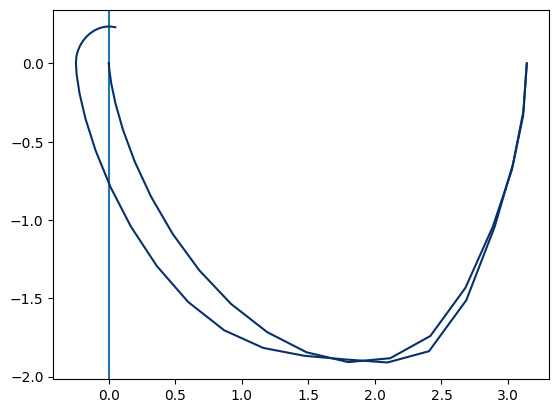

In [15]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_nom = EllipsoidTubeData2D(center_data=X_init, ellipsoid_data=None)
plot_data_nom_sim = EllipsoidTubeData2D(center_data=X_init_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)

# GP training

We use a model with different parameters to emulate the real-world model and obtain some training data. Also create simulator object for real-world model to evaluate our results later (not used in solver).

## Generate training data

We generate training data (one-step ahead residuals `y_train` for starting point `x_train`) here by running robustified (cautious) solver without GP.

In [16]:
random_seed = 123
N_sim_per_x0 = 1
N_x0 = 10
x0_rand_scale = 0.1

x_train, x0_arr = generate_train_inputs_acados(
    acados_ocp_init_solver,
    x0,
    N_sim_per_x0,
    N_x0,
    random_seed=random_seed,
    x0_rand_scale=x0_rand_scale,
)

y_train = generate_train_outputs_at_inputs(
    x_train, acados_integrator, acados_integrator_actual, Sigma_W
)

In [17]:
x_train

array([[ 3.18088649e+00, -4.27721330e-02, -2.00000000e+00],
       [ 3.14642964e+00, -3.71665627e-01, -2.00000000e+00],
       [ 3.05642391e+00, -7.10902620e-01, -2.00000000e+00],
       [ 2.90836978e+00, -1.06980940e+00, -1.99999999e+00],
       [ 2.69821910e+00, -1.45750357e+00, -1.27978832e+00],
       [ 2.43053847e+00, -1.76088571e+00, -7.37493675e-02],
       [ 2.12599282e+00, -1.89914567e+00,  7.89365122e-01],
       [ 1.80795759e+00, -1.92067400e+00,  1.38237979e+00],
       [ 1.49331422e+00, -1.85574036e+00,  1.75891100e+00],
       [ 1.19482125e+00, -1.72431954e+00,  1.95930025e+00],
       [ 9.22287699e-01, -1.54238918e+00,  1.99999967e+00],
       [ 6.82682085e-01, -1.32827300e+00,  1.95932910e+00],
       [ 4.80547511e-01, -1.09266933e+00,  1.81560481e+00],
       [ 3.17956492e-01, -8.54277414e-01,  1.60997530e+00],
       [ 1.94188189e-01, -6.27628162e-01,  1.36343640e+00],
       [ 1.06280148e-01, -4.24862352e-01,  1.09242229e+00],
       [ 4.94638519e-02, -2.55365369e-01

## Hyper-parameter training for GP model

Optimize hyper-parameters of GP model (kernel function parameters, ...)

In [18]:
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
nout = y_train.shape[1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=nout)
gp_model = BatchIndependentMultitaskGPModel(x_train_tensor, y_train_tensor, likelihood)

In [19]:
load_gp_model_from_state_dict = False
state_dict_path_gp_model = "gp_model_state_dict.pth"
state_dict_path_likelihood = "gp_model_likelihood_state_dict.pth"
train_data_path = "gp_model_train_data.pth"

if load_gp_model_from_state_dict:
    # Load state dict
    gp_model.load_state_dict(torch.load(state_dict_path_gp_model))
    likelihood.load_state_dict(torch.load(state_dict_path_likelihood))
else:
    training_iterations = 200
    rng_seed = 456

    gp_model, likelihood = train_gp_model(
        gp_model, torch_seed=rng_seed, training_iterations=training_iterations
    )

# EVAL MODE
gp_model.eval()
likelihood.eval()

Iter 20/200 - Loss: 0.634
Iter 40/200 - Loss: -0.382
Iter 60/200 - Loss: -1.336
Iter 80/200 - Loss: -1.928
Iter 100/200 - Loss: -2.038
stopping GP optimization early after 105 iterations.


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [20]:
# save GP hyper-params
torch.save(gp_model.state_dict(), state_dict_path_gp_model)
torch.save(likelihood.state_dict(), state_dict_path_likelihood)
torch.save({"x_train": x_train_tensor, "y_train": y_train_tensor}, train_data_path)

In [21]:
data_dict = torch.load(train_data_path)
data_dict

{'x_train': tensor([[ 3.1809e+00, -4.2772e-02, -2.0000e+00],
         [ 3.1464e+00, -3.7167e-01, -2.0000e+00],
         [ 3.0564e+00, -7.1090e-01, -2.0000e+00],
         [ 2.9084e+00, -1.0698e+00, -2.0000e+00],
         [ 2.6982e+00, -1.4575e+00, -1.2798e+00],
         [ 2.4305e+00, -1.7609e+00, -7.3749e-02],
         [ 2.1260e+00, -1.8991e+00,  7.8937e-01],
         [ 1.8080e+00, -1.9207e+00,  1.3824e+00],
         [ 1.4933e+00, -1.8557e+00,  1.7589e+00],
         [ 1.1948e+00, -1.7243e+00,  1.9593e+00],
         [ 9.2229e-01, -1.5424e+00,  2.0000e+00],
         [ 6.8268e-01, -1.3283e+00,  1.9593e+00],
         [ 4.8055e-01, -1.0927e+00,  1.8156e+00],
         [ 3.1796e-01, -8.5428e-01,  1.6100e+00],
         [ 1.9419e-01, -6.2763e-01,  1.3634e+00],
         [ 1.0628e-01, -4.2486e-01,  1.0924e+00],
         [ 4.9464e-02, -2.5537e-01,  8.0858e-01],
         [ 1.7619e-02, -1.2589e-01,  5.1917e-01],
         [ 3.6839e-03, -4.0943e-02,  2.2800e-01],
         [ 9.5272e-10, -3.1625e-03,  3.

## Plot GP predictions

We plot GP predictions along the predicted trajectory of the robustified solver by projecting the multivariate plot down to a line.

In [22]:
x_train.shape, y_train.shape

((300, 3), (300, 2))

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

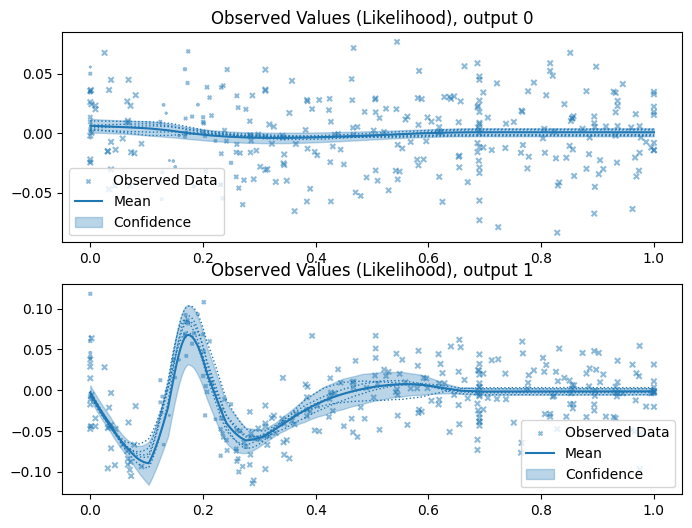

In [23]:
num_samples = 5
use_likelihood = False

num_points_between_samples = 30
t_lin = np.linspace(0, 1, num_points_between_samples, endpoint=False)

x_plot_waypts = np.hstack((X_init[1:, :], U_init))
x_plot = []
for i in range(x_plot_waypts.shape[0] - 1):
    x_plot += [
        x_plot_waypts[i, :] + (x_plot_waypts[i + 1, :] - x_plot_waypts[i, :]) * t
        for t in t_lin
    ]
x_plot = np.vstack(x_plot)

gp_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=num_samples, use_likelihood=use_likelihood
)
plot_gp_data([gp_data], marker_size_lim=[1, 15])

We can also plot the derivative of the GP. Note that the projected Jacobian is not smooth since our path is not smooth either (jump projection direction = jump in Jacobian); however, the actual Jacobian should be smooth here (squared exponential kernel).

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

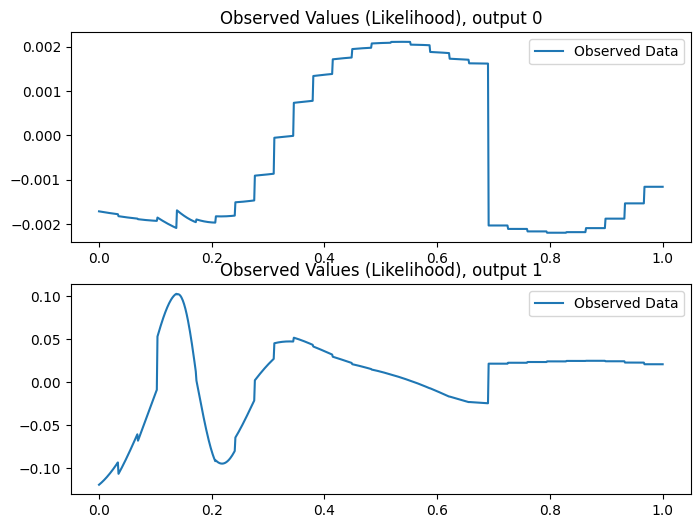

In [24]:
gp_derivative_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=0
)
plot_gp_data([gp_derivative_data], marker_size_lim=[5, 20], plot_train_data=False)

Compare with plotting along a slice of the dimension. Since we generated training data along the path of the robustified controller, the GP looks pretty untrained along a slice of the coordinates.

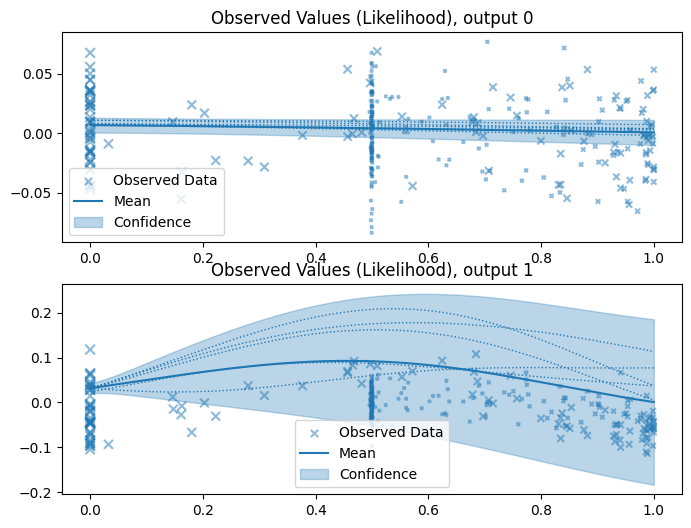

In [25]:
# plot along axis
x_dim_lims = np.array([[0, np.pi], [-2, 1], [-2, 2]])
x_dim_slice = np.array([1 * np.pi, 0, 0])
x_dim_plot = 2
x_grid = generate_grid_points(x_dim_lims, x_dim_slice, x_dim_plot, num_points=800)

gp_grid_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=num_samples, use_likelihood=use_likelihood
)
fig, ax = plot_gp_data([gp_grid_data], marker_size_lim=[5, 50])

y_lim_0 = ax[0].get_ylim()
y_lim_1 = ax[1].get_ylim()

Jacobian... not much going on away from the data points (this is good!)

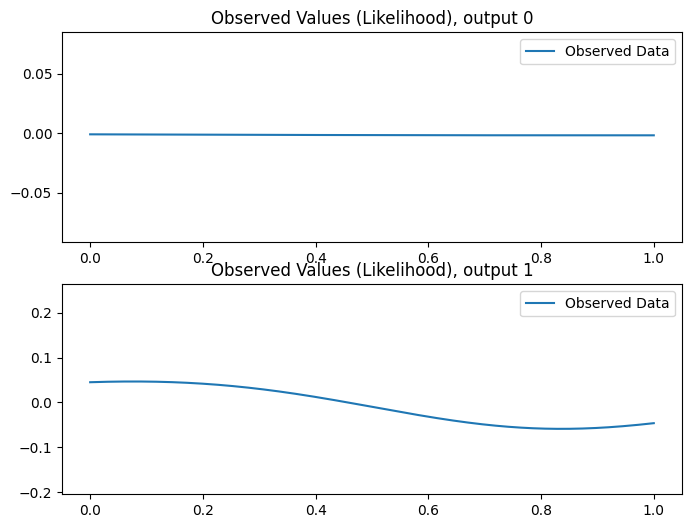

In [26]:
gp_derivative_grid_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=0
)
fig, ax = plot_gp_data(
    [gp_derivative_grid_data], marker_size_lim=[5, 50], plot_train_data=False
)

ax[0].set_ylim(*y_lim_0)
ax[1].set_ylim(*y_lim_1)
plt.draw()

# Residual-Model MPC

In [27]:
from zero_order_gpmpc.models.gpytorch_models.gpytorch_residual_model import (
    GPyTorchResidualModel,
)

In [28]:
residual_model = GPyTorchResidualModel(gp_model)

In [29]:
residual_model.evaluate(x_plot_waypts[0:3, :])

array([[ 0.00623822, -0.00300592],
       [ 0.00561822, -0.04082772],
       [ 0.00489497, -0.07332181]], dtype=float32)

In [30]:
residual_model.jacobian(x_plot_waypts[0:3, :])

array([[[ 0.00081569,  0.00156562, -0.00097137],
        [ 0.00084895,  0.00162579, -0.00099601],
        [ 0.00088611,  0.00167132, -0.00102427]],

       [[ 0.14768472,  0.08627499,  0.05330689],
        [ 0.13136345,  0.06240475,  0.06151862],
        [ 0.10249931,  0.02255215,  0.0689545 ]]], dtype=float32)

In [31]:
residual_model.value_and_jacobian(x_plot_waypts[0:3, :])

(array([[ 0.00623822, -0.00300592],
        [ 0.00561822, -0.04082772],
        [ 0.00489497, -0.07332181]], dtype=float32),
 array([[[ 0.00081569,  0.00156562, -0.00097137],
         [ 0.00084895,  0.00162579, -0.00099601],
         [ 0.00088611,  0.00167132, -0.00102427]],
 
        [[ 0.14768472,  0.08627499,  0.05330689],
         [ 0.13136345,  0.06240475,  0.06151862],
         [ 0.10249931,  0.02255215,  0.0689545 ]]], dtype=float32))

In [32]:
residual_mpc = ZeroOrderGPMPC(
    ocp_init,
    sim,
    prob_x,
    Sigma_x0,
    Sigma_W,
    h_tightening_idx=[0],
    gp_model=residual_model,
    use_cython=False,
    path_json_ocp="residual_mpc_ocp_solver_config.json",
    path_json_sim="residual_mpc_sim_solver_config.json",
    build_c_code=True,
)

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_linear_model_with_params_nx2_nu1_np0.so
rm -f linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun.o custom_update_function_gpzoro.o acados_solver_linear_model_with_params_nx2_nu1_np0.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/acados/include -I/home/amon/Repositories/acados/include/acados -I/home/amon/Repositories/acados/include/blasfeo/include -I/home/amon/Repositories/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home

In [33]:
for i in range(N):
    residual_mpc.ocp_solver.set(i, "x", X_init[i, :])
    residual_mpc.ocp_solver.set(i, "u", U_init[i, :])
residual_mpc.ocp_solver.set(N, "x", X_init[N, :])

residual_mpc.solve()
X_res, U_res = residual_mpc.get_solution()
P_res_arr = residual_mpc.covariances_array

P_res = []
for i in range(N + 1):
    # P_res.append(P_res_arr[i * nx**2 : (i + 1) * nx**2].reshape((nx, nx)))
    P_res.append(
        np.array(
            [
                [P_res_arr[3 * i], P_res_arr[3 * i + 2]],
                [P_res_arr[3 * i + 2], P_res_arr[3 * i + 1]],
            ]
        )
    )
P_res = np.array(P_res)

initing 30 solve stat fields
residuals after  0 SQP_RTI iterations:
 [2.61799388e+00 7.35311061e-02 1.19647285e+00 2.76992488e-10]
residuals after  1 SQP_RTI iterations:
 [2.66304725e-01 8.04389506e-02 1.01304460e+00 2.91093153e-10]
residuals after  2 SQP_RTI iterations:
 [1.91562983e-01 4.58628141e-02 1.16562562e+00 3.75820840e-09]
residuals after  3 SQP_RTI iterations:
 [1.98234486e-01 7.70563858e-02 1.12403047e+00 3.04573421e-15]
residuals after  4 SQP_RTI iterations:
 [2.02983781e-01 4.48045171e-02 1.14881132e+00 3.08536991e-15]
residuals after  5 SQP_RTI iterations:
 [1.96649722e-01 7.33021448e-02 1.13208041e+00 9.48673267e-12]
residuals after  6 SQP_RTI iterations:
 [2.02650628e-01 4.33747336e-02 1.13316509e+00 3.68299749e-13]
residuals after  7 SQP_RTI iterations:
 [1.94910109e-01 7.09522699e-02 1.12674772e+00 2.20358494e-11]
residuals after  8 SQP_RTI iterations:
 [2.02189478e-01 4.27432588e-02 1.12610121e+00 1.16555037e-12]
residuals after  9 SQP_RTI iterations:
 [1.94110491e-

In [34]:
X_res_sim = np.zeros_like(X_res)
X_res_sim[0, :] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_res_sim[i, :])
    acados_integrator_actual.set("u", U_res[i, :])
    acados_integrator_actual.solve()
    X_res_sim[i + 1, :] = acados_integrator_actual.get("x")

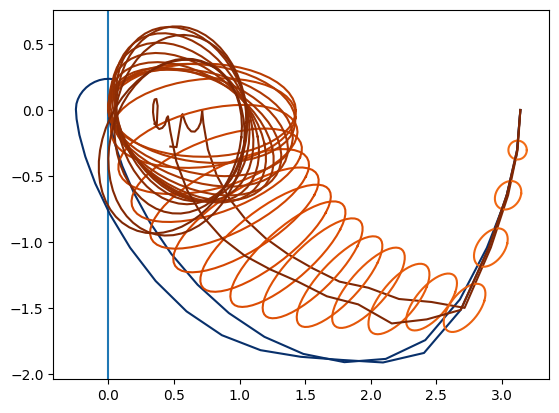

In [35]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_res = EllipsoidTubeData2D(center_data=X_res, ellipsoid_data=P_res)
plot_data_res_sim = EllipsoidTubeData2D(center_data=X_res_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, color_fun=plt.cm.Blues)
add_plot_trajectory(
    ax, plot_data_res, prob_tighten=prob_tighten, color_fun=plt.cm.Oranges
)
add_plot_trajectory(ax, plot_data_res_sim, color_fun=plt.cm.Oranges)